# Mixture Density Network 1D Regression

This tutorial will showcase the application of a fairly "old" (in ML age) modeling technique called Mixture Density Networks that can be used for supervised regression problems, as well as inverse problems. For a very nice tutorial, with more mathematical details, see [this tutorial](https://github.com/dusenberrymw/mixture-density-networks/blob/master/mixture_density_networks.ipynb).

In [1]:
%%capture
%pip install lightning-uq-box

## Imports

In [26]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DeterministicRegression, MDNRegression
from lightning_uq_box.viz_utils import (
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [4]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

In [5]:
dm = ToyHeteroscedasticDatamodule(n_points=500)

X_train, Y_train, train_loader, X_test, Y_test, test_loader, X_gtext, Y_gtext = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
    dm.X_gtext,
    dm.Y_gtext,
)

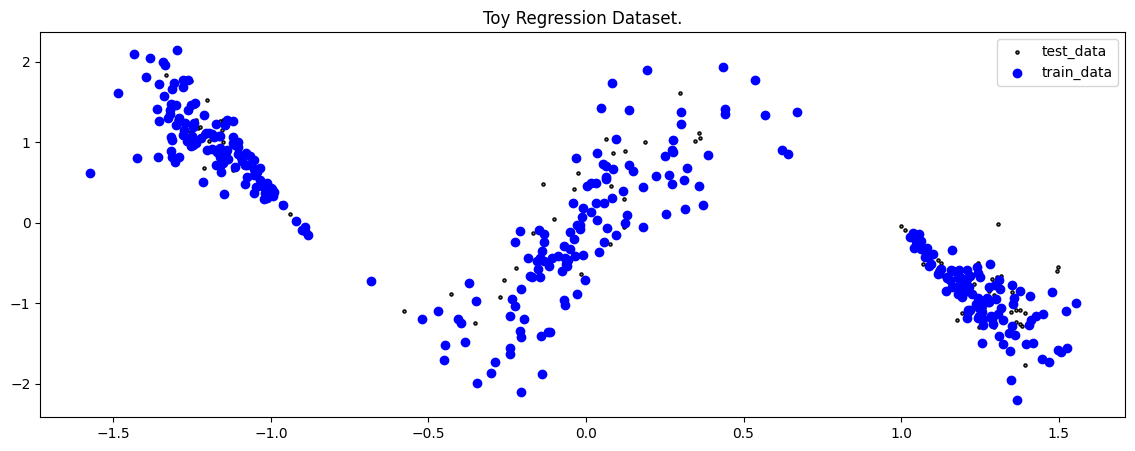

In [6]:
fig = plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

## Deterministic Model

For this toy regression problem, we will use a simple Mulit-layer Perceptron (MLP).

In [7]:
network = MLP(
    n_inputs=1,
    n_hidden=[50, 50, 50],
    n_outputs=1,
    dropout_p=0.1,
    activation_fn=nn.Tanh(),
)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)

## Fit deterministic model

In [8]:
det_model = DeterministicRegression(
    model=network, loss_fn=nn.MSELoss(), optimizer=partial(Adam, lr=0.003)
)

In [9]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=20,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

trainer.fit(det_model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmp2t51mro4/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in t

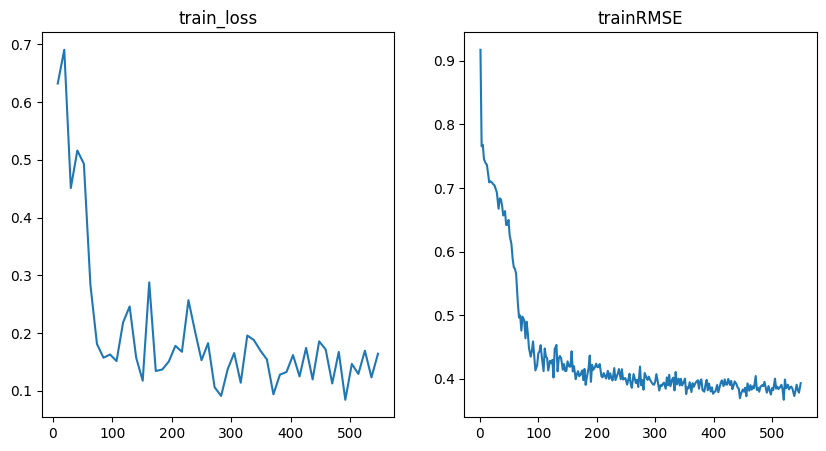

In [10]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

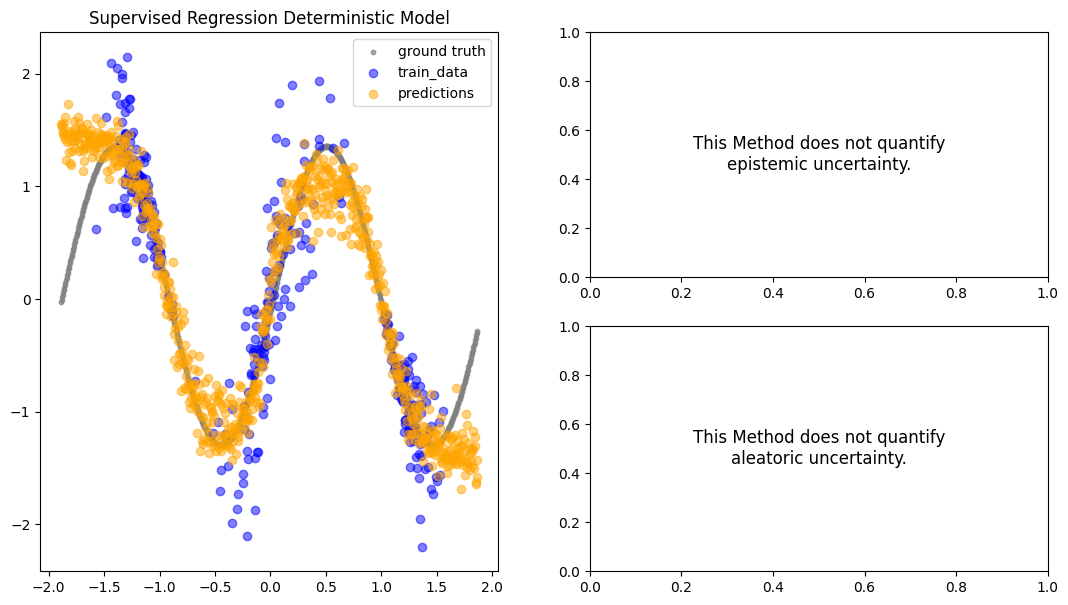

In [11]:
deterministic_preds = det_model.predict_step(X_gtext)
fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_gtext,
    Y_gtext,
    deterministic_preds["pred"].squeeze(-1),
    title="Supervised Regression Deterministic Model",
)

## Fit deterministic model on inverse problem

Okay, this is standard stuff, but what happens if we consider an inverse problem, where we swap X and Y and then solve for Y.

In [28]:
dm_inverse = ToyHeteroscedasticDatamodule(n_points=500, invert=True)

X_train_inv, Y_train_inv, X_test_inv, Y_test_inv, X_gtext_inv, Y_gtext_inv = (
    dm_inverse.X_train,
    dm_inverse.Y_train,
    dm_inverse.X_test,
    dm_inverse.Y_test,
    dm_inverse.X_gtext,
    dm_inverse.Y_gtext,
)

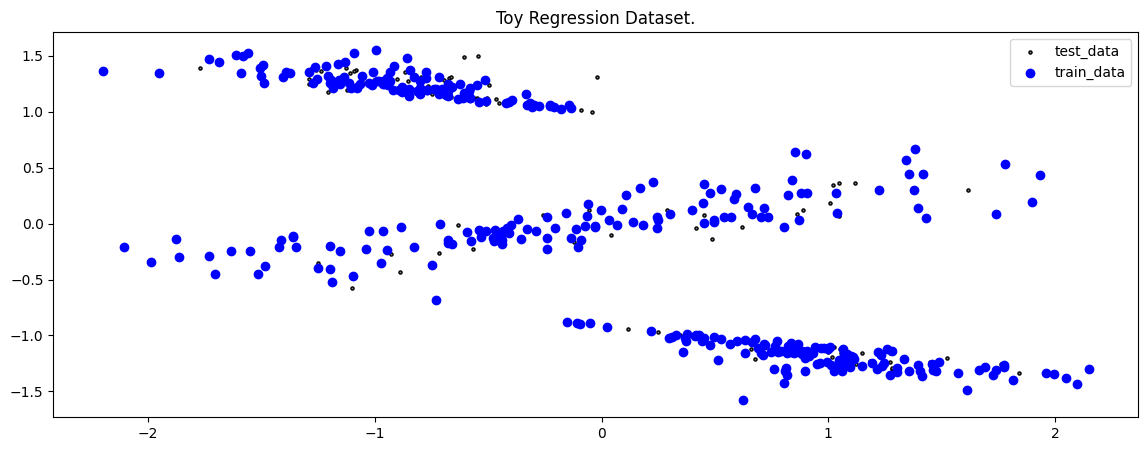

In [29]:
fig = plot_toy_regression_data(X_train_inv, Y_train_inv, X_test_inv, Y_test_inv)

In [30]:
network = MLP(
    n_inputs=1,
    n_hidden=[50, 50, 50],
    n_outputs=1,
    dropout_p=0.1,
    activation_fn=nn.Tanh(),
)
det_inv_model = DeterministicRegression(
    model=network, loss_fn=nn.MSELoss(), optimizer=partial(Adam, lr=0.003)
)

In [31]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=20,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

trainer.fit(det_inv_model, dm_inverse)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/mini

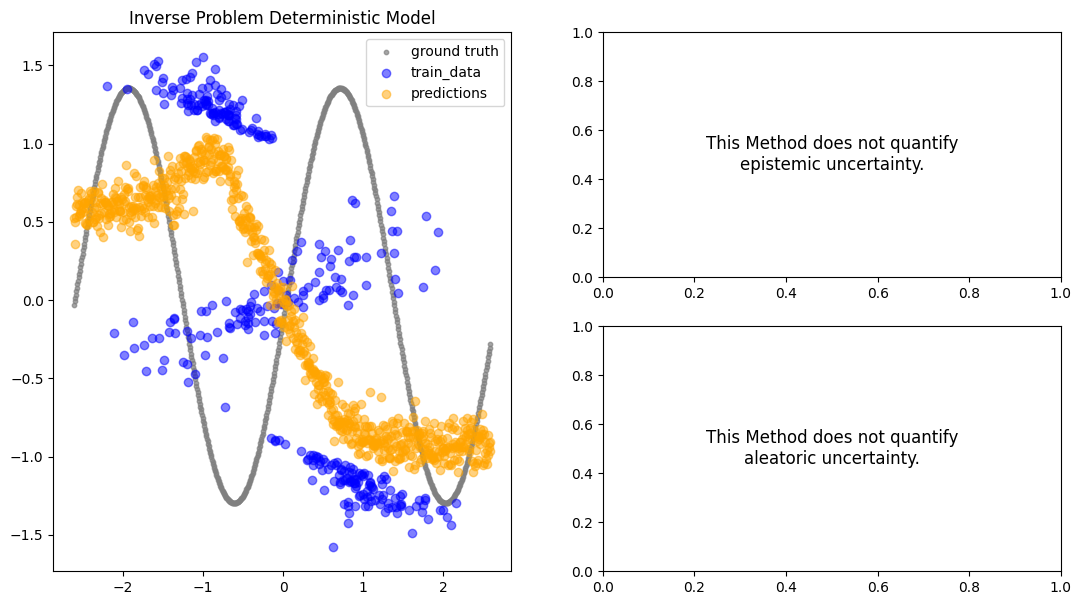

In [34]:
det_inv_preds = det_inv_model.predict_step(X_gtext_inv)
fig = plot_predictions_regression(
    X_train_inv,
    Y_train_inv,
    X_gtext_inv,
    # Y_gtext_inv,
    Y_gtext_inv,
    det_inv_preds["pred"].squeeze(-1),
    title="Inverse Problem Deterministic Model",
)

We can see that the model has difficulties fitting the data, as it tries to find a deterministic mapping for this multi-modal dataset.

## Mixture Density Network Model

The Mixture Density Network tackles the inverse problem by instead modeling the data as a mixture of multiple distributions, and effectively train a neural network to parameterize a Gaussian Mixture Model.

For the inverse problem, we will again use a simple Mulit-layer Perceptron (MLP), but adapt it afterwards for the Mixture Density Network idea.

In [35]:
mdn_temp_dir = tempfile.mkdtemp()

In [36]:
mdn_base_network = MLP(
    n_inputs=1,
    n_hidden=[50, 50, 50],
    n_outputs=1,
    dropout_p=0.1,
    activation_fn=nn.Tanh(),
)
mdn_base_network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)

We will create a model with a Mixture Density Layer as the last layer. This last layer will replace the last layer of the specified MLP architecture above, such that the method remains applicable for "off-the-shelve" models like found in [timm](https://github.com/huggingface/pytorch-image-models) as well as custom architectures of course. You can also only train the last layer and keep all other parameters frozen (via the `freeze_backbone` flag), which might be interesting for finetuning pretrained models to have a probabilistic output. 

In [37]:
mdn_model = MDNRegression(
    model=mdn_base_network, n_components=3, optimizer=partial(Adam, lr=0.003)
)

In [38]:
logger = CSVLogger(mdn_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=20,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

trainer.fit(mdn_model, dm_inverse)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmp6_g7pdxb/lightning_logs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | MLP                | 10.8 K
1 | loss_fn       | MixtureDensityLoss | 0     
2 | train_metrics | MetricCollection   | 0     
3 | val_metrics   | MetricCollection   | 0     
4 | test_metrics  | MetricCollection   | 0     
-----------------------------------------------------
10.8 K    Trainable params
0         Non-trainable params
10.8 K    Total params
0.043     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=250` reached.


We can take a brief look at the loss to check whether the model has been trained to reasonable convergence.

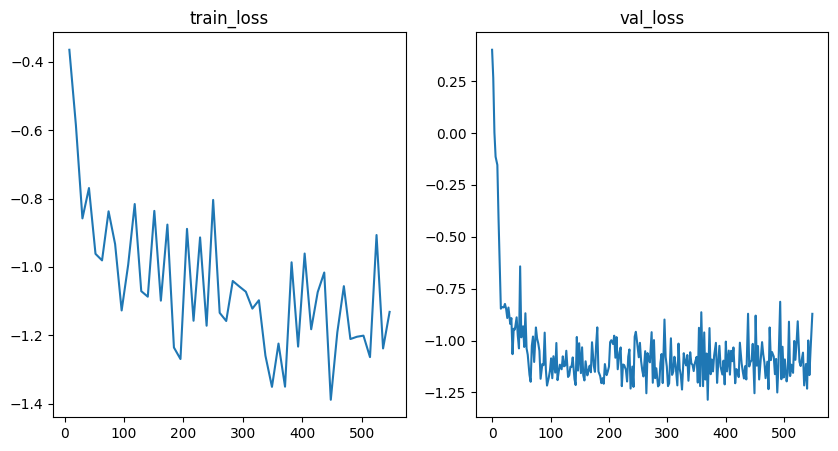

In [39]:
fig = plot_training_metrics(
    os.path.join(mdn_temp_dir, "lightning_logs"), ["train_loss", "val_loss"]
)

## Plot Predictions

Now we are ready for the "big reveal", namely whether we can fit the data more accurately with the Mixture Density approach.

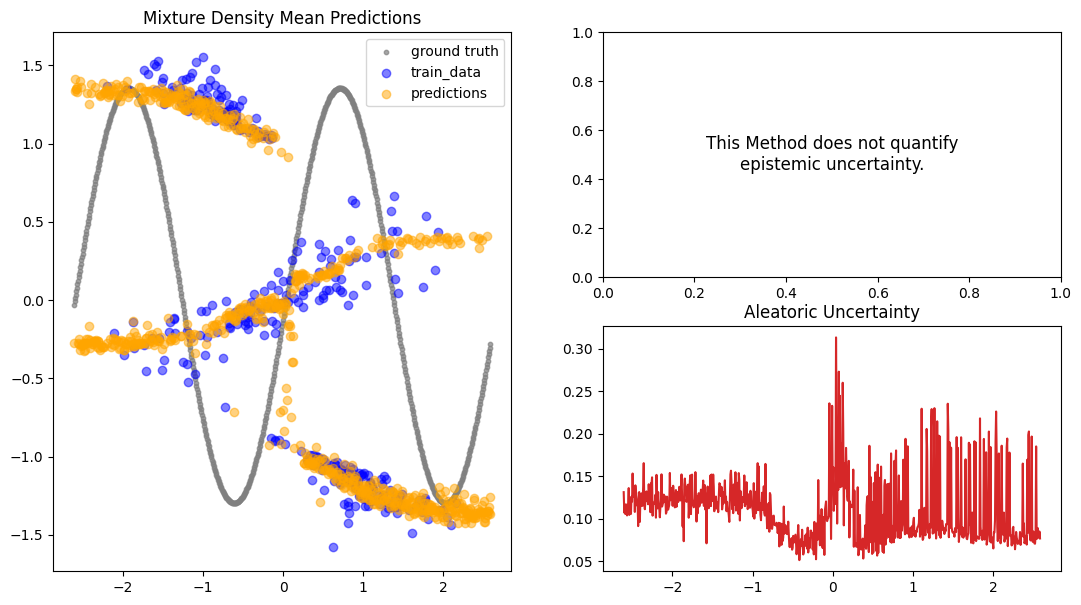

In [40]:
mixture_density_pred = mdn_model.predict_step(X_gtext_inv)

fig = plot_predictions_regression(
    X_train_inv,
    Y_train_inv,
    X_gtext_inv,
    Y_gtext_inv,
    mixture_density_pred["pred"],
    aleatoric=mixture_density_pred["pred_uct"],
    title="Mixture Density Mean Predictions",
    show_bands=False,
)

## Sampling

We can also draw conditional samples from the mixture distributions.

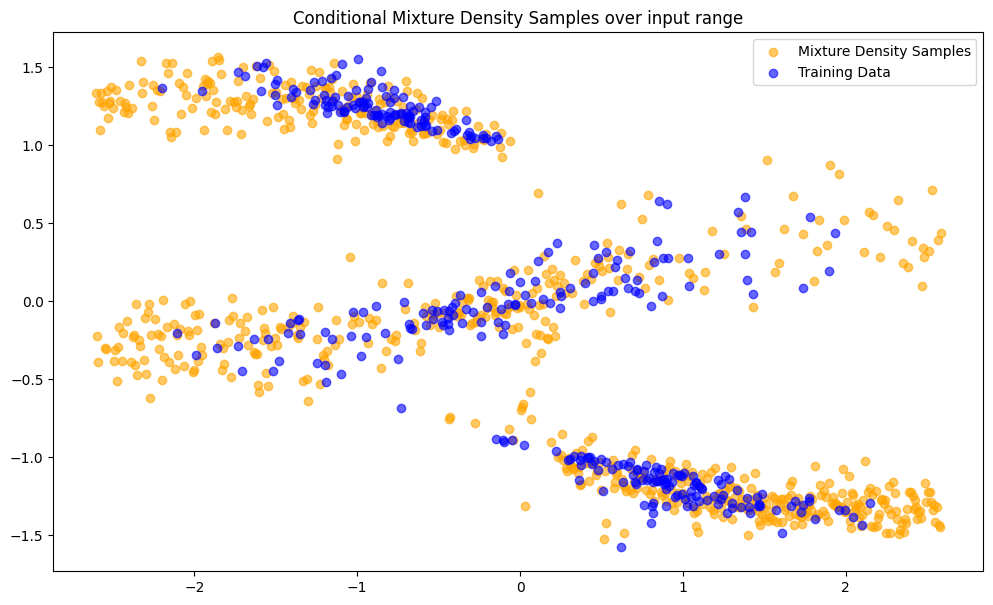

In [55]:
mixture_density_samples = mdn_model.sample(X_gtext_inv)

fig, axs = plt.subplots(1, figsize=(12, 7))

axs.scatter(
    X_gtext_inv,
    mixture_density_samples.squeeze(-1).T,
    color="orange",
    alpha=0.6,
    label="Mixture Density Samples",
)
axs.scatter(X_train_inv, Y_train_inv, color="blue", label="Training Data", alpha=0.6)

axs.set_title("Conditional Mixture Density Samples over input range")
plt.legend()

It looks like the Mixture Density Model was able to approximate $p(y|x)$ of the inverse problem reasonably well, much better than a default deterministic network.